In [1]:
import random
import numpy as np
import torch
import os
import pathlib
import pickle
from gurobipy import *
from rsome import ro
from rsome import grb_solver as grb
import rsome as rso
from rsome import cpt_solver as cpt

In [2]:
# data_generation_process = "SPO_Data_Generation"
data_generation_process = "DDR_Data_Generation"

# Parameters

In [ ]:
# import pyepo
# generate data
grid = (5,5) # grid size
num_train = 100 # number of training data
num_feat = 5 # size of feature
num_test = 1000
deg = 1.0 # polynomial degree
e = 100 # scale of normal std or the range of uniform. For the error term

lower = 0 # coef lower bound
upper = 1 # coef upper bound
p = num_feat # num of features
d = (grid[0] - 1) * (grid[0] - 1) * 2 + 2 * (grid[0] - 1) # num of arcs
num_nodes = grid[0]*grid[0]
alpha = e # scale of normal std or the range of uniform. For the error term
mis = deg # model misspecification
coef_seed = 1

In [4]:
current_directory = os.getcwd()
parent_directory = os.path.dirname(current_directory)
grandparent_directory = os.path.dirname(parent_directory)
DataPath = os.path.dirname(grandparent_directory) + '/Data/Test0326_' + data_generation_process + "/"
pathlib.Path(DataPath).mkdir(parents=True, exist_ok=True)
print("grandparent_directory:", grandparent_directory)
print("DataPath:", DataPath)
DataPath = DataPath + "data_size="+str(num_train)+"_deg="+str(deg)+"_e="+str(e)+"_d="+str(d)+"_coef_seed="+str(coef_seed)+"/"
pathlib.Path(DataPath).mkdir(parents=True, exist_ok=True)

grandparent_directory: /Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Code_MacBook
DataPath: /Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data/Test0326_DDR_Data_Generation/


# Generate Data

In [5]:
def Prepare_Data(DataPath,lower, upper, p, d, coef_seed,seed_all,num_test, num_train, alpha,mis,data_generation_process):
# #  ****** Coef generation *********
    from Data import data_generation
    data_gen = data_generation()
    # print("W_star = ",W_star[0,:])
    W_star = data_gen.generate_truth(DataPath,lower, upper, p, d, coef_seed,version = 0) 
    
    x_test_all = {}; c_test_all = {}; x_train_all = {}; c_train_all = {}; W_star_all = {}
    for seed in seed_all:
        DataPath_seed = DataPath +"Seed="+str(seed)+"/"
        pathlib.Path(DataPath_seed).mkdir(parents=True, exist_ok=True)
        # #  ****** Data generation *********
        x_test_all[seed], c_test_all[seed], x_train_all[seed], c_train_all[seed], W_star_all[seed] = data_gen.generate_samples(seed,DataPath_seed,p, d, num_test, num_train, alpha, W_star, mis, thres = 10, 
                                version = data_generation_process, x_dist = 'normal', e_dist = 'normal', x_low = 0, x_up = 2, x_mean = 2, x_var = 0.025, bump = 100) 
        # print()
    return x_test_all, c_test_all, x_train_all, c_train_all, W_star_all

# EPO(SPO+,...)

In [6]:
# from PYEPO import PyEPO_Method
# epo_runner = PyEPO_Method()
def Implement_EPO(DataPath,seed_all,batch_size,num_epochs,method_names,x_train_all,c_train_all,x_test_all,c_test_all,arcs,epo_runner):
    cost_EPO = {}
    # batch_size = 20
    # num_epochs = 30
    for seed in seed_all:
        DataPath_seed = DataPath +"Seed="+str(seed)+"/"
        pathlib.Path(DataPath_seed).mkdir(parents=True, exist_ok=True)
        print("*** seed = ",seed,": Run EPO ******")
        cost_EPO[seed] = epo_runner.run(method_names,DataPath_seed,batch_size,num_feat,grid,num_epochs,\
                                        x_train_all[seed],c_train_all[seed],x_test_all[seed],c_test_all[seed],arcs)
    return cost_EPO

# Obtain DDR estimation

### define network

In [7]:
def _getArcs(grid):
    arcs = []
    for i in range(grid[0]):
        # edges on rows
        for j in range(grid[1] - 1):
            v = i * grid[1] + j
            arcs.append((v, v + 1))
        # edges in columns
        if i == grid[0] - 1:
            continue
        for j in range(grid[1]):
            v = i * grid[1] + j
            arcs.append((v, v + grid[1]))

    arc_index_mapping = {}
    for i in range(len(arcs)):
        arc = arcs[i]
        arc_index_mapping[arc] = i

    return arcs,arc_index_mapping

In [8]:
def solve_DDR(arcs,lamb,mu_fixed,num_nodes,x_train,c_train):
    
    N,p = x_train.shape
    N,d = c_train.shape

    # DDR
    m = Model("ddr")
    #m.setParam("DualReductions",0)
    m.setParam('OutputFlag', 0)

    W_ind = tuplelist( [(i,j) for i in range(d) for j in range(p)] )
    w0_ind = tuplelist( [i for i in range(d)])

    W_ddr = m.addVars(W_ind, lb=-GRB.INFINITY,name = "W" )
    w0_ddr = m.addVars(w0_ind, lb=-GRB.INFINITY,name = "W0" )
    alpha = m.addVars(N,num_nodes,lb=-GRB.INFINITY,name="alpha")
    expr_obj = 0
    err = []
    for n in range(N):
        cost_true_tem = c_train[n]
        expr_obj = expr_obj + alpha[n,num_nodes-1] - alpha[n,0]
        for ind in range(len(arcs)):
            cost_pred_tem = quicksum([W_ddr[ind,j] * x_train[n,j] for j in range(p)]) + w0_ddr[ind]
            err.append(cost_true_tem[ind] - cost_pred_tem)
            e = arcs[ind]
            j = e[1]
            i = e[0]
            # print("j = ",j,", i = ",i, ", e = ",e)
            m.addConstr(alpha[n,j] - alpha[n,i] >= -mu_fixed*cost_true_tem[ind] - (1-mu_fixed)*cost_pred_tem)

    m.setObjective(quicksum([err[k] * err[k] for k in range(len(err))])/N + lamb*(expr_obj)/N, GRB.MINIMIZE)
    m.optimize()
    
    W_DDR_rst = m.getAttr('x', W_ddr)
    w0_DDR_rst = m.getAttr('x', w0_ddr)
    W_ddr_val = []
    for i in range(d):
        W_ddr_val.append([W_DDR_rst[(i,j)] for j in range(p)])
    w0_ddr_val = [w0_DDR_rst[i] for i in range(d)]

    alpha_rst = m.getAttr('x', alpha)
    return w0_ddr_val,W_ddr_val,alpha_rst,m.ObjVal

# Out-of-sample performance

### Generate data

In [24]:
arcs,arc_index_mapping = _getArcs(grid)
num_arcs = len(arcs)
seed_all = np.arange(1,10)
# obtain data
x_test_all, c_test_all, x_train_all, c_train_all, W_star_all = Prepare_Data(DataPath,lower, upper, p, d, coef_seed,seed_all,num_test, num_train, alpha,mis,data_generation_process)

### EPO performance

In [10]:
# # EPO, including SPO, PG, LTR
# batch_size = 20
# num_epochs = 30
# method_names = ["spo+","pg","ltr"]

# from PYEPO import PyEPO_Method
# epo_runner = PyEPO_Method()
# cost_EPO_all = Implement_EPO(DataPath,[1],batch_size,num_epochs,method_names,x_train_all,c_train_all,x_test_all,c_test_all,arcs,epo_runner)
# # OLS

### OLS performance

In [25]:
from OLS import ols_method
ols_method_obj = ols_method()
from Peformance import performance_evaluation
perfs = performance_evaluation()
W_ols_all = {}; w0_ols_all = {}; t_ols_all = {}; obj_ols_all = {}
cost_OLS_all = {}; cost_Oracle_all = {}

for seed in seed_all:
    # compute OLS performance
    W_ols_all[seed], w0_ols_all[seed], t_ols_all[seed], obj_ols_all[seed] = ols_method_obj.ols_solver("",x_train_all[seed], c_train_all[seed])
    cost_OLS_all[seed] = perfs.compute_Cost_with_Prediction(arcs,w0_ols_all[seed],W_ols_all[seed], grid,c_test_all[seed],x_test_all[seed])
    cost_Oracle_all[seed] = perfs.compute_Oracel_Cost(arcs, grid,c_test_all[seed])

In [12]:
# seed = 1
# demand_esti = x_train_all[seed] @ np.asarray(W_ols_all[seed]).T + w0_ols_all[seed]
# np.mean(demand_esti[0,:])
# np.mean(c_train_all[seed][0,:])

### DDR performance

In [13]:
def obtain_DDR_out_of_sample_performance(mu,lamb_all,num_nodes,x_train,c_train,x_test,c_test,cost_OLS,cost_Oracle,perfs):

    regret_arr = np.zeros(len(lamb_all))
    lamb_index = 0
    cost_DDR = {}; w0_ddr_dict = {}; W_ddr_dict = {}
    for lamb in lamb_all:
        w0_ddr_dict[lamb],W_ddr_dict[lamb],alpha_rst,obj_ddr = solve_DDR(arcs,lamb,mu,num_nodes,x_train,c_train)
        cost_DDR[lamb] = perfs.compute_Cost_with_Prediction(arcs,w0_ddr_dict[lamb],W_ddr_dict[lamb], grid,c_test,x_test)
        regret_arr[lamb_index] = (np.nanmean(cost_OLS) - np.nanmean(cost_DDR[lamb]) )/(np.nanmean(cost_OLS) - np.nanmean(cost_Oracle)) * 100
        lamb_index = lamb_index + 1
        # print("seed=",seed,",mu=",mu_fixed,",lamb=",lamb,",obj_ddr=",obj_ddr,",regret=",regret_arr[lamb_index])
    return regret_arr,cost_DDR,w0_ddr_dict,W_ddr_dict

In [ ]:
mu = 0.9
lamb_all = np.round(np.arange(1,30,2),2)
regret_all = {}; cost_DDR_all = {}; w0_ddr_all = {}; W_ddr_all = {}
for seed in seed_all:
    regret_all[seed,mu],cost_DDR_all[seed,mu],w0_ddr_all[seed,mu],W_ddr_all[seed,mu] = obtain_DDR_out_of_sample_performance(mu,lamb_all,num_nodes,x_train_all[seed],c_train_all[seed],x_test_all[seed],c_test_all[seed],cost_OLS_all[seed],cost_Oracle_all[seed],perfs)
    print("seed=",seed,",mu=",mu,"regret=",np.round(regret_all[seed,mu],4))

seed= 1 ,mu= 0.85 regret= [ 0.1294 -0.173   0.3233  0.5268  0.5785  0.4386  0.3102  0.2309 -0.5157
 -0.7658 -0.6898 -0.7239 -0.99   -1.3187 -1.8089]
seed= 2 ,mu= 0.85 regret= [-0.0472  0.2214  0.0866  0.1956  0.047   0.3811  0.5161  0.6436  0.4607
  0.7276  1.0124  1.3385  1.2048  1.076   0.7937]
seed= 3 ,mu= 0.85 regret= [-0.2562 -0.1362 -0.0026 -0.0435 -0.1369 -0.1977 -0.1328 -0.3199 -0.5014
 -0.7902 -0.8147 -0.9646 -0.887  -0.9122 -0.9078]
seed= 4 ,mu= 0.85 regret= [ 0.0347 -0.1745 -0.7274 -0.7113 -1.014  -1.2248 -1.239  -1.3883 -1.2066
 -1.0292 -1.2661 -1.5252 -1.4684 -1.2493 -1.4868]
seed= 5 ,mu= 0.85 regret= [-0.3417 -0.1315 -0.1482 -0.0145  0.1453  0.0473  0.2869 -0.0851  0.071
  0.1776  0.338   0.0575 -0.2737 -0.2282 -0.0419]
seed= 6 ,mu= 0.85 regret= [-0.2417 -0.2343 -0.1518 -0.2431 -0.2269 -0.2243 -0.2102 -0.0385 -0.1862
 -0.3241 -0.0951 -0.0156 -0.3528 -0.6827 -0.6154]
seed= 7 ,mu= 0.85 regret= [ 0.0887  0.2475  0.1431 -0.0536 -0.0634 -0.084  -0.0979  0.0581 -0.0019
 -0.3163

In [15]:
# seed = 1
# lamb = 15
# cost_OLS_esti = x_test_all[seed] @ np.asarray(W_ols_all[seed]).T + w0_ols_all[seed]
# cost_DDR_esti = x_test_all[seed] @ np.asarray(W_ddr_all[seed,mu][lamb]).T + w0_ddr_all[seed,mu][lamb]

# S_test_index = 3
# print("cost_DDR_esti=",cost_DDR_esti[S_test_index,])
# print("cost:(0,1)-->(1,3) = ",cost_DDR_esti[S_test_index,0] + cost_DDR_esti[S_test_index,2])
# print("cost:(0,2)-->(2,3) = ",cost_DDR_esti[S_test_index,1] + cost_DDR_esti[S_test_index,3])

# print("cost_OLS_esti=",cost_OLS_esti[S_test_index,])
# print("cost:(0,1)-->(1,3) = ",cost_OLS_esti[S_test_index,0] + cost_OLS_esti[S_test_index,2])
# print("cost:(0,2)-->(2,3) = ",cost_OLS_esti[S_test_index,1] + cost_OLS_esti[S_test_index,3])


# print("cost_Oracle=",c_test_all[seed][S_test_index])
# print("cost:(0,1)-->(1,3) = ",c_test_all[seed][S_test_index,0] + c_test_all[seed][S_test_index,2])
# print("cost:(0,2)-->(2,3) = ",c_test_all[seed][S_test_index,1] + c_test_all[seed][S_test_index,3])

In [40]:
regret_avg = np.zeros(len(lamb_all))
for seed in seed_all:
    regret_avg = regret_avg + regret_all[seed,mu]
regret_avg = regret_avg/(len(seed_all))
print("regret_avg=",np.round(regret_avg,4))

regret_avg= [-0.0651 -0.0233 -0.0508 -0.0021 -0.0369 -0.0768 -0.1476 -0.2613 -0.3754
 -0.3845 -0.3699 -0.4459 -0.6311 -0.7395 -0.8496]


# Plot figures

In [17]:
def cross_compare2plus(c_item, c_base, c_oracle):
    c_item = np.asarray(c_item)
    c_base = np.asarray(c_base)
    c_oracle = np.asarray(c_oracle)

    N = len(c_item)
    c_diff = c_item - c_base
    lbel = np.zeros((N,1))
    
    equals = np.sum(c_diff == 0)
    wins = np.sum(c_diff < 0)
    lose = np.sum(c_diff > 0)
    
    lbel[c_diff < 0] = 1
    lbel[c_diff > 0] = -1
    
    # print("Num_train =",N,",Num_equals =",equals,",Num_wins =",wins,",Num_lose =",lose)
    # print("base cost = ", np.mean(c_base),",item cost = ",np.mean(c_item))
    if N == equals:
        win_ratio = 0.5
    else:
        win_ratio = wins/(N - equals)
    # cost_reduction = (np.mean(c_base) - np.mean(c_item) )/np.abs(np.mean(c_oracle))
    regret_reduction = (np.nanmean(c_base) - np.nanmean(c_item))/np.abs(np.nanmean(c_base) - np.nanmean(c_oracle))
    return lbel, win_ratio, regret_reduction

In [28]:
H2H_DDR_vs_OLS_all = {}; regret_reduction_DDR_vs_OLS_all = {}
for lamb in lamb_all:
    H2H_DDR_vs_OLS_arr = np.zeros(len(seed_all)); regret_reduction_DDR_vs_OLS_arr = np.zeros(len(seed_all))
    seed_index = 0
    print("lamb = ",lamb)
    for seed in seed_all:
        lbel, H2H_DDR_vs_OLS_arr[seed_index], regret_reduction_DDR_vs_OLS_arr[seed_index] = cross_compare2plus(cost_DDR_all[seed,mu][lamb],cost_OLS_all[seed], cost_Oracle_all[seed])
        seed_index = seed_index + 1
    H2H_DDR_vs_OLS_all[mu,lamb] = H2H_DDR_vs_OLS_arr; regret_reduction_DDR_vs_OLS_all[mu,lamb] = regret_reduction_DDR_vs_OLS_arr

lamb =  10
lamb =  12
lamb =  14
lamb =  16
lamb =  18
lamb =  20
lamb =  22
lamb =  24
lamb =  26
lamb =  28
lamb =  30
lamb =  32
lamb =  34
lamb =  36
lamb =  38
lamb =  40
lamb =  42
lamb =  44
lamb =  46
lamb =  48
lamb =  50
lamb =  52
lamb =  54
lamb =  56
lamb =  58
lamb =  60
lamb =  62
lamb =  64
lamb =  66
lamb =  68
lamb =  70
lamb =  72
lamb =  74
lamb =  76
lamb =  78
lamb =  80
lamb =  82
lamb =  84
lamb =  86
lamb =  88
lamb =  90
lamb =  92
lamb =  94
lamb =  96
lamb =  98


In [29]:
lamb_all

array([10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42,
       44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76,
       78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98])

In [31]:
H2H_DDR_vs_OLS_all[mu,lamb]

array([0.55384615, 0.53333333, 0.45945946, 0.34848485, 0.56862745,
       0.5       , 0.47368421, 0.59459459, 0.5308642 ])

In [32]:
regret_reduction_DDR_vs_OLS_all[mu,lamb]

array([ 0.0082468 ,  0.00300794, -0.00135015, -0.01091107,  0.00135606,
       -0.00159362,  0.00050412,  0.00433946,  0.00089517])

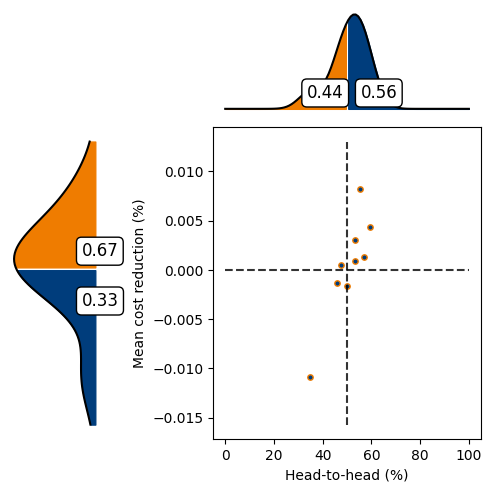

In [33]:
lamb = 12
import Figures
Figures.figure_plot_upleft(H2H_DDR_vs_OLS_all[mu,lamb]*100, regret_reduction_DDR_vs_OLS_all[mu,lamb], "", size = (5, 5), move = [-0.12, 0.04, 0.35, 0.55], 
                    ysame = 0, yrange = [6,6], sublabel = '', ypio = 0)

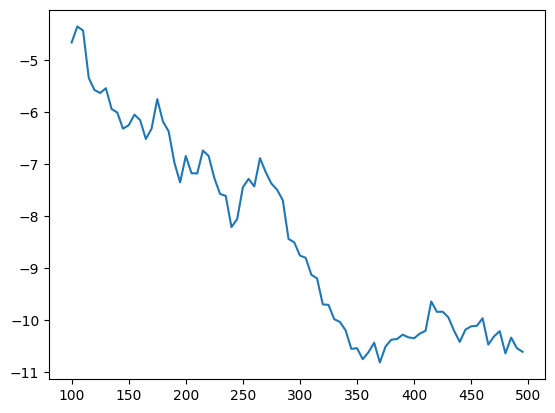

In [22]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = plt.subplot()
ax.plot(lamb_all,regret_all[seed,mu])